$\newcommand{\myvector}[2]{\left\{ \begin{array}{c}#1\\#2\end{array} \right\}}$
$\newcommand{\mymatrix}[4]{\left[ \begin{array}{c}#1&#2\\#3&#4\end{array} \right]}$
$\newcommand{\sM}[1]{\boldsymbol{s}_{\mathrm{M#1}}}$
$\newcommand{\rvector}[1]{\boldsymbol{r}_{\mathrm{#1}}}$

# APPENDIX D:  Bayesian and least-squares results divergence


This Appendix describes a minimal inverse kinematics model for which Bayesian and least-sqaures results diverge.


### Model

The planar mechanism depicted below has two degrees of freedom (DOF): one translational and one rotational. The first (slider) segment moves to a position $y$ and the second segment rotates about point A to an angle $\theta$. Two markers (M1 and M2) are rigidly fixed to the rotating segment and have fixed local positions:  $\sM{1} = \myvector{35}{0}$ and $\sM{2} = \myvector{45}{0}$.

<img src="figs/rotating_slider.png" width="450">


The three points' true global positions are:

\begin{align}
\rvector{A} &= \myvector{0}{y}\\ \\
\rvector{M1} &= \rvector{A} + \boldsymbol{R} \ \sM{1}\\ \\
\rvector{M2} &= \rvector{A} + \boldsymbol{R} \ \sM{2}
\end{align}

where $\boldsymbol{R}$ is the rotation matrix:

\begin{equation}
\boldsymbol{R} = \mymatrix{\cos\theta}{-\sin\theta}{\sin\theta}{\cos\theta}
\end{equation}

### Inverse kinematics (IK) problem

Imagine that we have measured the following marker positions:

\begin{align}
\rvector{M1}' &= \myvector{33.51}{12.11}\\ \\
\rvector{M2}' &= \myvector{42.63}{16.18}
\end{align}

The IK problem is to estimate $y$ and $\theta$ given these measurements.

For argument's sake let's say we also happen to know that the true values of the unknown variables are: $y$ = 0 and $\theta$ = 20 deg. In this case the true global marker positions are:

\begin{align}
\rvector{M1} &= \myvector{32.89}{11.97}\\ \\
\rvector{M2} &= \myvector{42.29}{15.39}
\end{align}

Let's assemble everything we know into Python for later use in our IK solutions.


<IPython.core.display.Javascript object>


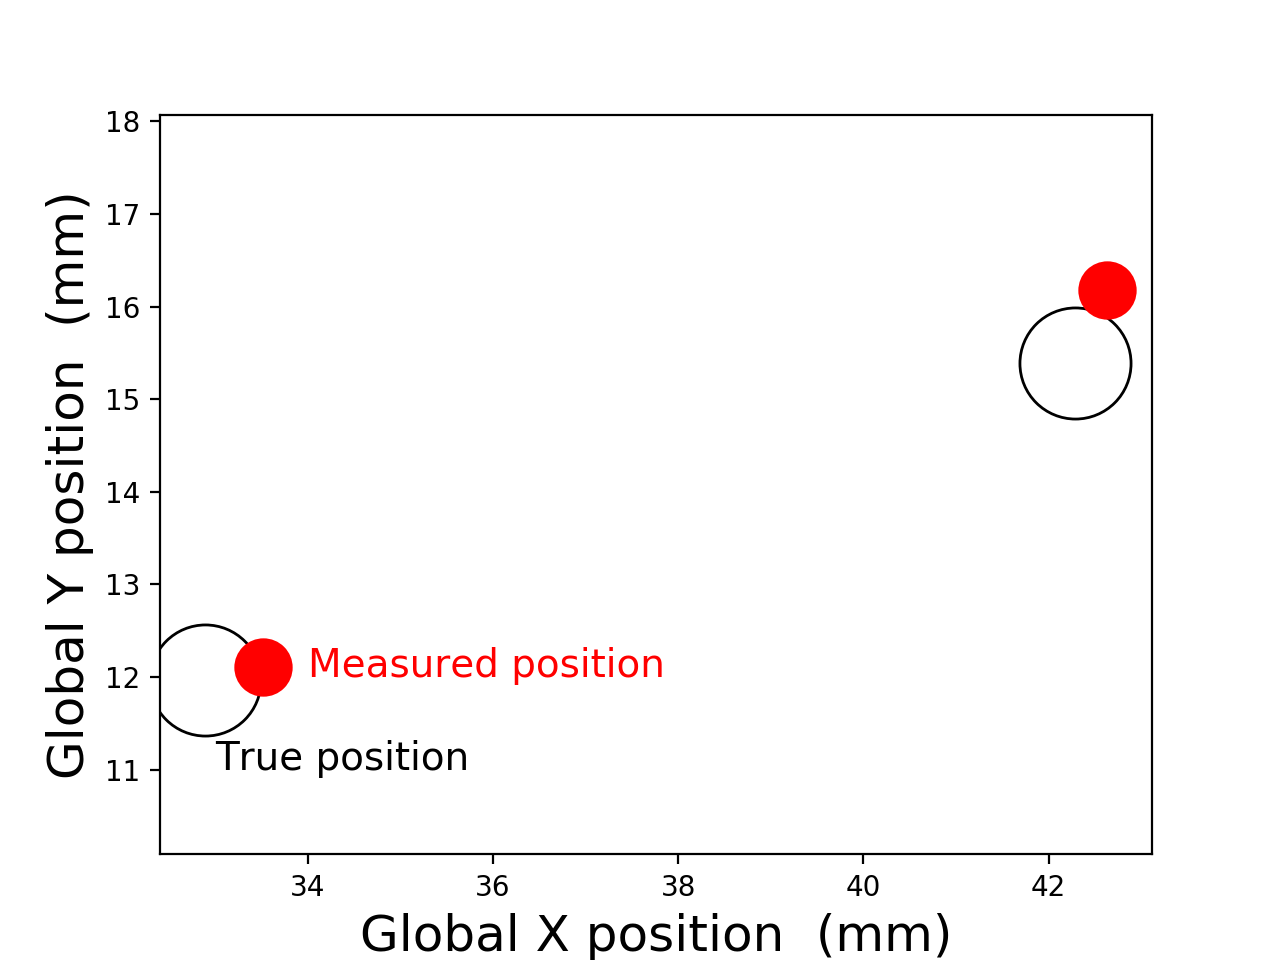

In [1]:
%matplotlib notebook

from math import sin,cos,radians,degrees
import numpy as np
from matplotlib import pyplot

#(0) Define known values:
### local positions:
sM1        = np.array([35.0, 0.0])
sM2        = np.array([45.0, 0.0])
### measurements:
rpM1       = np.array([33.51, 12.11])
rpM2       = np.array([42.63, 16.18])
### true values: (not used in IK solutions, but useful for visualization)
y_true     = 0.0
theta_true = radians(20)



#(1) Compute global marker positions given y and theta:
def rotation_matrix(theta):
    '''Construct rotation matrix'''
    c,s    = cos(theta), sin(theta)
    R      = np.matrix(  [[c, -s], [s, c]] )
    return R

def rotate(R, r):
    '''Rotate a position vector r using rotation matrix R'''
    return np.asarray(  (R * np.mat(r).T)  ).flatten()

def get_positions(y, theta):
    '''Compute global marker positions given y and theta'''
    rA     = np.array([0, y])       #global A position
    R      = rotation_matrix(theta)
    rM1    = rA + rotate(R, sM1)    #global M1 position
    rM2    = rA + rotate(R, sM2)    #global M2 position
    return rM1,rM2

rM1,rM2    = get_positions(y_true, theta_true)



#(2) Plot:
pyplot.figure()
ax = pyplot.axes()
ax.plot(rM1[0],  rM1[1],  'o', markeredgecolor='k', markerfacecolor='w', ms=40)
ax.plot(rM2[0],  rM2[1],  'o', markeredgecolor='k', markerfacecolor='w', ms=40)
ax.plot(rpM1[0], rpM1[1], 'o', markeredgecolor='r', markerfacecolor='r', ms=20)
ax.plot(rpM2[0], rpM2[1], 'o', markeredgecolor='r', markerfacecolor='r', ms=20)
ax.text(33, 11, 'True position',     color='k', size=14)
ax.text(34, 12, 'Measured position', color='r', size=14)
ax.set_xlabel('Global X position  (mm)', size=18)
ax.set_ylabel('Global Y position  (mm)', size=18)
pyplot.axis('equal')
pyplot.show()

# Least-squares solution

This IK problem is relatively simple, so it could be solved using an analytical approach similar to the one presented in Appendix B. However, we'll be a bit lazy and instead solve the IK problem numerically, using the "get_positions" function that we've already written above.

Once we set values for $y$ and $\theta$ we know the global positions of $\rvector{M1}$ and $\rvector{M2}$, so we can compute the difference between those positions and our measurements as:

\begin{align}
\boldsymbol{\epsilon}_1 &= \rvector{M1}' - \rvector{M1}\\
\boldsymbol{\epsilon}_2 &= \rvector{M2}' - \rvector{M2}
\end{align}

We can then express total measurement error as follows:


\begin{equation}
f(y, \theta) =
\big| \ \boldsymbol{\epsilon}_1 \ \big| \ ^2 \
+ \
\big| \ \boldsymbol{\epsilon}_2 \ \big| \ ^2
\end{equation}

Although we have called $f(y, \theta)$ a "measurement error" function, the opposite perspective is equally apt: "guess error".  That is, if we know our measurement values ($\rvector{M1}'$, $\rvector{M2}'$) and then use $y$ and $\theta$ to guess the true marker positions ($\rvector{M1}$, $\rvector{M2}$), then $f(y, \theta)$ represents our guess error. We nevertheless use "measurement error" below because we presume there is no guess which can yield zero error. 

For later purposes let's bundle our two unknown variables into a generalized "unknowns" vector $\boldsymbol{x}$ as follows:


\begin{align}
\boldsymbol{x} = \myvector{y}{\theta}
\end{align}

Now our error function is:

\begin{align}
f(\boldsymbol{x}) =
\big| \ \boldsymbol{\epsilon}_1 \ \big| \ ^2 \
+ \
\big| \ \boldsymbol{\epsilon}_2 \ \big| \ ^2
\end{align}

Let's implement this function in Python and then explore its output to make sure it's returning reasonable values.


In [2]:
def measurement_error(x):
    y,theta = x 
    rM1,rM2 = get_positions(y, theta)
    e1,e2   = rpM1 - rM1, rpM2 - rM2
    e1,e2   = np.linalg.norm(e1), np.linalg.norm(e2)
    f       = e1**2 + e2**2
    return f

x = [0, radians(20)]
print( measurement_error(x) )

1.14563304519


Here the total measurement error is 1.146 mm$^2$. By moving to a different vertical position (e.g. $y$=2) or a different angular position ($\theta$=10 deg) we see that measurement error increases:

In [3]:
print(   measurement_error( [2, radians(20)] )   )
print(   measurement_error( [0, radians(10)] )   )

5.43207890941
110.13801125


Since we can compute the error function $f(y,\theta)$ for arbitrary $y$ and $\theta$ values we can view it as a three-dimensional surface as follows:

<IPython.core.display.Javascript object>


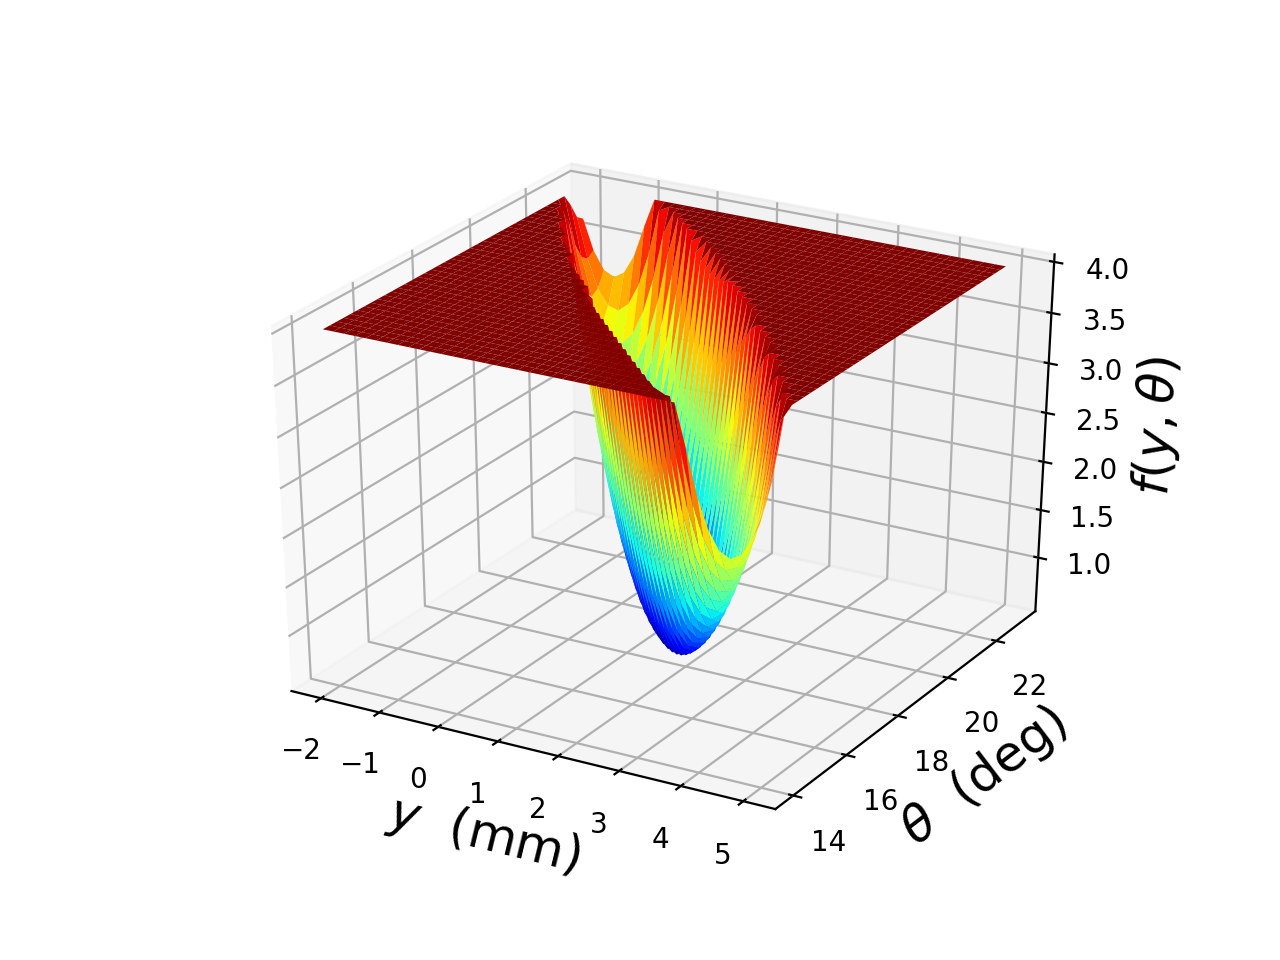

In [4]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


### Compute error for a range of y and theta values:
Y       = np.linspace(-2, 5, 41)
THETA   = np.radians( np.linspace(14, 23, 41) )
Y,THETA = np.meshgrid(Y, THETA)
F       = [measurement_error(x)   for x in zip(Y.flatten(), THETA.flatten())]
F       = np.reshape(F, Y.shape)
F[F>4]  = 4  #cap all values at 4 to more clearly see the function's minimum


### Plot:
fig     = pyplot.figure()
ax      = fig.gca(projection='3d')
ax.plot_surface(Y, np.degrees(THETA), F, cmap=cm.jet, rstride=1, cstride=1, linewidth=0.2)
ax.set_xlabel(r'$y$  (mm)', size=18)
ax.set_ylabel(r'$\theta$  (deg)', size=18)
ax.set_zlabel(r'$f(y, \theta)$', size=18)
pyplot.show()

In the figure above it appears that our error function's minimum value occurs for approximately $y$=1.5 and $\theta$=19, but let's find its minimum value algorithmically using **scipy.optimize.minimize** as follows:

In [5]:
from scipy import optimize

x0       = [0, radians(20)]  #initial (y, theta) guess
results  = optimize.minimize(measurement_error, x0)

print('Least-squares estimates:')
print('   y     = %.3f' %results.x[0])
print('   theta = %.3f' %degrees(results.x[1]) )

Least-squares estimates:
   y     = 1.321
   theta = 18.700


Due to measurement error our final estimates for $y$ and $\theta$ are slightly different from their true values ($y$=0, $\theta$=20).

# Bayesian approach

The figure below depicts a stochastic forward-kinematics model for this system.  Once the numerical values of $y$ and $\theta$ are known we know the values of our deterministic variables $\rvector{M1}$ and $\rvector{M2}$.  Similarly, once the numerical value of our measurement error $\epsilon$ is known we will also know the value of our generalized measurement vector $\boldsymbol{q}$, where $\boldsymbol{q}$ contains all four measured coordinates from $\rvector{M1}'$ and $\rvector{M2}'$. Let's implement this model in PyMC.

<img src="figs/bikmodel2.png" width="300">

In [6]:
import pymc


q_observed = np.asarray([rpM1, rpM2]).flatten() #measured positions
tau        = 20  #presumed measurement precision (we'll relax this later)
y          = pymc.Normal("y", 0, 1)  #prior for y
theta      = pymc.Uniform("theta", radians(-45), radians(45))  #prior for theta


@pymc.deterministic
def observations_model(y=y, theta=theta):
    rM1,rM2 = get_positions(y, theta)
    q       = np.asarray([rM1, rM2]).flatten()
    return q
q_model   = pymc.Normal("q", observations_model, tau, value=q_observed, observed=True)

Now that we have a model of our observations we can set values for $y$ and $\theta$ and then check what kinds of results our model produces.

In [7]:
y.set_value(0)
theta.set_value( radians(20) )
print( q_model.random() )
print( q_model.random() )
print( q_model.random() )

[ 32.78484058  11.89083546  42.45642173  16.02977362]
[ 33.28954332  11.9619234   42.19980949  15.71036284]
[ 32.77358118  12.14726452  42.56477381  15.23909662]


The first two columns represent $\rvector{M1}'$ and the last two columns represent $\rvector{M2}'$.  We can see that these values are similar to our actual measured values, so our model appears to have been specified correctly. 

Variability exists in these values because we have not set the value of our last stochastic variable ($\epsilon$); this variability is built into the model above via the parameter "tau" which specifies our measurement precision.  If we raise tau to a very high value we will see that the model's results become much less variable.

In [8]:
tau       = 1e9
q_model   = pymc.Normal("q", observations_model, tau, value=q_observed, observed=True)
print( q_model.random() )
print( q_model.random() )
print( q_model.random() )
print( q_model.random() )
print( q_model.random() )

[ 32.88928498  11.97068501  42.28618804  15.39089926]
[ 32.88924399  11.97076292  42.28616353  15.39089276]
[ 32.88931438  11.97073356  42.2861079   15.39092759]
[ 32.88925868  11.97070977  42.2862221   15.39091137]
[ 32.88926231  11.97067152  42.2861532   15.390917  ]


Now let's relax our assumptions regarding tau's true value, then use PyMC to run Markov-Chain Monte-Carlo simulations with the goal of finding posterior distributions for $y$ and $\theta$ (and tau) which are most consistent with the observed marker positions.

In [9]:
tau        = pymc.Normal("tau", 20, 1)  #prior for measurement precision
y          = pymc.Normal("y", 0, 1)     #prior for y
theta      = pymc.Uniform("theta", radians(-45), radians(45))  #prior for theta

@pymc.deterministic
def observations_model(y=y, theta=theta):
    rM1,rM2 = get_positions(y, theta)
    q       = np.asarray([rM1, rM2]).flatten()
    return q
q_model   = pymc.Normal("q", observations_model, tau, value=q_observed, observed=True)


mcmc      = pymc.MCMC([q_model, y, theta, tau])
mcmc.sample(40000, 20000)
Y         = mcmc.trace('y')[:]
THETA     = np.degrees( mcmc.trace('theta')[:] )
TAU       = np.degrees( mcmc.trace('tau')[:] )

print('\n\nBayesian estimates:')
print('   y     = %.3f' %Y.mean() )
print('   theta = %.3f' %THETA.mean() )

 [-----------------100%-----------------] 40000 of 40000 complete in 7.7 sec

Bayesian estimates:
   y     = 1.145
   theta = 18.923


Our Bayesian estimates for $y$ and $\theta$ are somewhat closer to their true values than are our least-squares estimates. But this is just for one case.  Let's now compare the two approaches' results more systematically.

# Systematic approach comparison

First let's pick some new true values for $y$ and $\theta$ and then generate ten random datasets based on those true values.

In [10]:
y_true      = -0.1
theta_true  = radians(5)
rM1,rM2     = get_positions(y_true, theta_true) 
q_true      = np.array([rM1, rM2]).flatten()

nIterations = 10
noise_amp   = 0.5
np.random.seed(0)
Q_obs       = q_true + noise_amp * np.random.randn(nIterations, 4)

print(Q_obs)

[[ 35.74884061   3.1505296   45.31813041   4.94245502]
 [ 35.80059343   2.46181206  45.30380562   3.74632982]
 [ 34.81520501   3.15575025  44.9007832    4.54914518]
 [ 35.2473333    3.0112885   45.05069303   3.98884559]
 [ 35.61385397   2.84787186  44.98529526   3.39496055]
 [ 33.59031953   3.27726029  45.26097951   3.45092591]
 [ 36.00169175   2.22326816  44.85164067   3.7284165 ]
 [ 35.63320404   3.68513038  44.90623513   4.01108968]
 [ 34.42292156   1.96005276  44.65480534   3.90018291]
 [ 35.48195977   3.55164092  44.63509801   3.67085705]]


These are the ten measurements we'll test. Let's first compute the least-squares solutions for each set of measurements.

In [11]:
def measurement_error(x, q_obs):
    y,theta = x
    rpM1    = q_obs[:2]
    rpM2    = q_obs[2:]
    rM1,rM2 = get_positions(y, theta)
    e1,e2   = rpM1 - rM1, rpM2 - rM2
    e1,e2   = np.linalg.norm(e1), np.linalg.norm(e2)
    f       = e1**2 + e2**2
    return f

def solution_ls(q_obs):
    x0      = [y_true, theta_true]  #initial (y, theta) guess
    results = optimize.minimize(measurement_error, x0, args=(q_obs,))
    y,theta = results.x
    return y, degrees(theta)

np.set_printoptions(precision=3, suppress=True)
RESULTS_LS  = np.array([solution_ls(q_obs)  for q_obs in Q_obs])
print('Least-squares results:')
print('   y     = %s' %RESULTS_LS[:,0])
print('   theta = %s' %RESULTS_LS[:,1])

Least-squares results:
   y     = [ 0.568  0.501 -0.742  0.672  1.625  1.289 -0.372  2.901 -3.663  3.141]
   theta = [ 4.988  3.732  6.596  4.055  2.144  2.974  4.801  1.356  9.488  0.674]


Next let's get Bayesian estimates for each dataset.

In [12]:
def solution_bayesian(q_obs):
    x0      = [y_true, theta_true]  #initial (y, theta) guess
    tau     = pymc.Normal("tau", 1/(noise_amp**2), 1)
    y       = pymc.Normal("y", y_true, 1, value=y_true)
    theta   = pymc.Uniform("theta", radians(-45), radians(45))

    @pymc.deterministic
    def observations_model(y=y, theta=theta):
        rM1,rM2 = get_positions(y, theta)
        q       = np.asarray([rM1, rM2]).flatten()
        return q
    q_model   = pymc.Normal("q", observations_model, tau, value=q_obs, observed=True)

    mcmc      = pymc.MCMC([q_model, y, theta, tau])
    mcmc.sample(40000, 20000, progress_bar=False)
    Y         = mcmc.trace('y')[:]
    THETA     = np.degrees( mcmc.trace('theta')[:] )
    
    return Y.mean(), THETA.mean()

RESULTS_B = np.zeros((nIterations,2))
for i,q_obs in enumerate(Q_obs):
    print('Iteration %d of %d...' %(i+1, nIterations))
    y,theta = solution_bayesian(Q_obs[0])
    RESULTS_B[i] = [y, theta]
    print('   y = %.3f,  theta = %.3f' %(y,theta))


Iteration 1 of 10...
   y = 0.112,  theta = 5.617
Iteration 2 of 10...
   y = 0.061,  theta = 5.694
Iteration 3 of 10...
   y = 0.044,  theta = 5.708
Iteration 4 of 10...
   y = 0.176,  theta = 5.506
Iteration 5 of 10...
   y = 0.095,  theta = 5.625
Iteration 6 of 10...
   y = 0.083,  theta = 5.662
Iteration 7 of 10...
   y = 0.151,  theta = 5.557
Iteration 8 of 10...
   y = 0.068,  theta = 5.681
Iteration 9 of 10...
   y = 0.052,  theta = 5.699
Iteration 10 of 10...
   y = 0.007,  theta = 5.772


Here is a summary of IK error for the two approaches:

In [13]:
x_true   = [y_true, degrees(theta_true)]
error_LS = RESULTS_LS - x_true
error_B  = RESULTS_B - x_true

print('Average absolute error (least-squares):')
print('   y: %.3f,  theta: %.3f' %tuple( np.abs(error_LS).mean(axis=0) ) )
print('Average absolute error (Bayesian):')
print('   y: %.3f,  theta: %.3f' %tuple( np.abs(error_B).mean(axis=0) ) )


Average absolute error (least-squares):
   y: 1.587,  theta: 2.136
Average absolute error (Bayesian):
   y: 0.185,  theta: 0.652


We can see that, on average, the Bayesian approach produces smaller errors for both $y$ and $\theta$.

However, you may have noticed that our calculations above have cheated a bit by using the true values of $y$ and $\theta$ as the algorithmic starting points.  Thus the results above suggest only that the Bayesian approach performs better than the least-squares approach when both start from the known true values of $y$ and $\theta$. In real IK applications the true values of $y$ and $\theta$ are of course unknown.  The main manuscript uses the true values of $y$ and $\theta$ as starting points only for LS estimation, to maximize its chances of converging to the true solution. The main manuscript then uses the LS solution as the starting point for the Bayesian estimate, to avoid potential biases associated with starting from the true solution. In other words, it gives LS estimation a huge advantage in finding the true maximum, but it gives Bayesian estimation no such advantage.

Finally, let's check how the least-squares and Bayesian approaches compare on a case-by-case basis.

In [14]:
error_difference = np.abs(error_LS) - np.abs(error_B)
print(error_difference)

[[ 0.457 -0.605]
 [ 0.44   0.574]
 [ 0.498  0.888]
 [ 0.496  0.439]
 [ 1.53   2.231]
 [ 1.206  1.364]
 [ 0.021 -0.358]
 [ 2.833  2.963]
 [ 3.412  3.789]
 [ 3.134  3.554]]


Positive values indicate that the least-squares solution had greater error and negative values indicate the opposite.  This shows that the Bayesian estimates for $y$ were better in all ten cases, and that the Bayesian estimates for $\theta$ were better in 8 of 10 cases.

# Summary

This Appendix shows that Bayesian and least-squares (LS) inverse kinematics (IK) estimates can diverge even for simple planar rotations. The results suggest that Bayesian IK performs better in general than LS-IK. Generally, *probabilistically* matching noisy data to a stochastic model via Bayesian techniques outperforms LS estimates derived from noisy data.